In [1]:
import os
import scipy.io as scio
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
from skyfield.api import EarthSatellite,load, wgs84
from skyfield.elementslib import osculating_elements_of
from pytz import timezone
from matplotlib.colors import cnames
from tqdm import tqdm
from multiprocessing import Pool
import statsmodels.api as sm
from matplotlib.pyplot import MultipleLocator

UTC = timezone('UTC')


## No need to run

In [2]:
orbit=pd.read_csv('../data/starlink-1409.csv')
starlinks=list(orbit['sat'])
tlepath='../data/tle-data/all_by_id/'
starttime=datetime.strptime("2022-4-1 0:0:0","%Y-%m-%d %H:%M:%S")
endtime=datetime.strptime("2022-7-20 0:0:0","%Y-%m-%d %H:%M:%S")
delta_time=(endtime-starttime).days*24*3600+(endtime-starttime).seconds
times=[starttime+timedelta(seconds=i) for i in range(0,delta_time,3600)]
satcat=pd.read_csv('../data/satcat/satcat.csv')

In [3]:
def get_isl_length_list(data,satid,nabor):
    isl=[]
    position1=data[satid]['position']
    position2=data[nabor]['position']
    for i in range(len(position1)):
        isl.append(math.sqrt((position1[i][0]-position2[i][0])**2+(position1[i][1]-position2[i][1])**2+(position1[i][2]-position2[i][2])**2))
    return isl

In [3]:
def get_isl_length_list(data,satid,nabor,t):
    #isl=[]
    position1=data[satid]['position']
    position2=data[nabor]['position']
    # for i in range(len(position1)):
    #     isl.append(math.sqrt((position1[i][0]-position2[i][0])**2+(position1[i][1]-position2[i][1])**2+(position1[i][2]-position2[i][2])**2))
    isl = math.sqrt((position1[t][0]-position2[t][0])**2+(position1[t][1]-position2[t][1])**2+(position1[t][2]-position2[t][2])**2)
    return isl

In [4]:
data_decay=np.load('../data/zhaow_decay_data.npy',allow_pickle=True).item()
data_no_decay=np.load('../data/zhaow_update_data.npy',allow_pickle=True).item()
orbit=pd.read_csv('../data/starlink-1409.csv')
orbit_num=len(orbit['No.orbit'].unique())
max_isl_length=5014
# orbit

In [5]:
# sat_1541=np.load('../data/sat_1541.npy')
# sat_1541=sat_1541.astype('int64')
sat_1541 = np.load('sat_dict_decay.npy',allow_pickle=True).item()
sat_1541 = list(sat_1541.keys())
#grid_topo=np.load('../data/topology_grid.npy')
neigh_gp_decay = np.load('neigh_gp_1hour_decay_v3.npy',allow_pickle=True).item()
neigh_gp_update = np.load('neigh_gp_1hour_update_v3.npy',allow_pickle=True).item()
result_have_neigh_decay = np.load('result_have_neigh_decay.npy',allow_pickle=True).tolist()
result_have_neigh_no_decay = np.load('result_have_neigh_update.npy',allow_pickle=True).tolist()
# limitless_topo=np.load('../data/topology_limitless.npy')

In [6]:
topology_decay = np.zeros((2640,len(sat_1541),len(sat_1541)),dtype = np.int)
for flag in neigh_gp_decay.keys():
    for t in range(2640):
        if(t % 1000 == 0):print(t)
        for key in neigh_gp_decay[flag][t].keys():
            if(result_have_neigh_decay[t][sat_1541.index(key)][list(neigh_gp_decay.keys()).index(flag)] != -1):
                neigh = neigh_gp_decay[flag][t][key][-1]
                topology_decay[t][sat_1541.index(key)][sat_1541.index(neigh)] = 1
                topology_decay[t][sat_1541.index(neigh)][sat_1541.index(key)] = 1

0
1000
2000
0
1000
2000


In [9]:
len(np.where(topology_decay[0][sat_1541.index(45184)] == 1)[0])

4

In [11]:
for t in range(2640):
    for i in range(len(topology_decay[t])):
        if(len(np.where(topology_decay[0][sat_1541.index(key)] == 1)[0]) > 4):
            print(t,sat_1541[i])

In [7]:
topology_update = np.zeros((2640,len(sat_1541),len(sat_1541)),dtype = np.int)
for flag in neigh_gp_update.keys():
    for t in range(2640):
        if(t % 1000 == 0):print(t)
        for key in neigh_gp_update[flag][t].keys():
            if(result_have_neigh_no_decay[t][sat_1541.index(key)][list(neigh_gp_update.keys()).index(flag)] != -1):
                neigh = neigh_gp_update[flag][t][key][-1]
                topology_update[t][sat_1541.index(key)][sat_1541.index(neigh)] = 1
                topology_update[t][sat_1541.index(neigh)][sat_1541.index(key)] = 1

0
1000
2000
0
1000
2000


In [8]:
for t in range(2640):
    for i in range(len(topology_update[t])):
        if(len(np.where(topology_update[0][sat_1541.index(key)] == 1)[0]) > 4):
            print(t,sat_1541[i])

In [25]:
int(np.where(sat_1541==45184)[0])

147

In [16]:
sat_1541[164]

45205

In [30]:
isl_data_decay={}
isl_data_no_decay={}

for satid in tqdm(orbit['sat'],desc="generating isl data"):
    #if(satid not in neigh_gp_update['inter'][0].keys()):continue
    orbit_index=list(orbit[orbit['sat']==satid]['No.orbit'])[0]
    # isl_data_decay[satid]={}
    # isl_data_no_decay[satid]={}
    isl_data_decay[satid]={'intra':[],'inter':[]}
    isl_data_no_decay[satid]={'intra':[],'inter':[]}
    for t in range(2640):
    # isl_data_decay[satid]={'intra1':[],'intra2':[],'inter1':[],'inter2':[]}
    # isl_data_no_decay[satid]={'intra1':[],'intra2':[],'inter1':[],'inter2':[]}
    #sat_index=np.where(sat_1541==satid)
        #sat_index = int(np.where(sat_1541==satid)[0])
        #print(sat_index)
        sat_index = sat_1541.index(satid)
        nabor_index_decay=np.where(topology_decay[t][sat_index]==1)
        #nabors=sat_1541[tuple(nabor_index)]
        #print(nabor_index_decay)
        nabor_index_decay= nabor_index_decay[0]
        nabors_decay = []
        for item in list(nabor_index_decay):
            #print(item)
            nabors_decay.append(sat_1541[item])
        #print(nabors_decay)
        flag_intra = 1
        flag_inter = 1
        for nabor in nabors_decay:
            if list(orbit[orbit['sat']==nabor]['No.orbit'])[0]==orbit_index:
                flag='intra'
            else:
                flag='inter'
            # isl_length_list=get_isl_length_list(data_decay,satid,nabor,t)
            # isl_data_decay[satid][flag].append(isl_length_list)
            #print(flag)
            isl_length_list=get_isl_length_list(data_decay,satid,nabor,t)
            if((flag == 'intra') and flag_intra == 1):
                isl_data_decay[satid][flag].append(isl_length_list)
                flag_intra = 0
            elif((flag == 'inter') and flag_inter == 1):
                isl_data_decay[satid][flag].append(isl_length_list)
                flag_inter = 0
        #print(isl_data_decay)
        #if(t == 1):break
        nabor_index_no_decay=np.where(topology_update[t][sat_index]==1)
        #nabors=sat_1541[tuple(nabor_index)]
        #print(nabor_index_decay)
        nabor_index_no_decay= nabor_index_no_decay[0]
        nabors_no_decay = []
        for item in list(nabor_index_no_decay):
            #print(item)
            nabors_no_decay.append(sat_1541[item])
        #print('2',nabors_no_decay)
        flag_intra = 1
        flag_inter = 1
        for nabor in nabors_no_decay:
            if list(orbit[orbit['sat']==nabor]['No.orbit'])[0]==orbit_index:
                flag='intra'
            else:
                flag='inter'
            isl_length_list=get_isl_length_list(data_no_decay,satid,nabor,t)
            if((flag == 'intra') and flag_intra == 1):
                isl_data_no_decay[satid][flag].append(isl_length_list)
                flag_intra = 0
            elif((flag == 'inter') and flag_inter == 1):
                isl_data_no_decay[satid][flag].append(isl_length_list)
                flag_inter = 0
        #print(isl_data_decay)
    #if(satid == 45182):break
    #sat_index=np.where(sat_1541==satid)
    # sat_index = sat_1541.index(satid)
    # nabor_index_no_decay=np.where(grid_topo[sat_index]==1)
    # #nabors=sat_1541[tuple(nabor_index)]
    # nabor_index_no_decay = nabor_index_no_decay[0]
    # nabors_no_decay = []
    # for item in nabor_index_no_decay:
    #     nabors_no_decay.append(sat_1541[item])
    # for nabor in nabors_no_decay:
    #     if list(orbit[orbit['sat']==nabor]['No.orbit'])[0]==orbit_index:
    #         flag='intra'
    #     else:
    #         flag='inter'
    #     # isl_length_list=get_isl_length_list(data_no_decay,satid,nabor,t)
    #     # isl_data_no_decay[satid][flag].append(isl_length_list)
    #     isl_length_list=get_isl_length_list(data_decay,satid,nabor,t)
    #     isl_data_decay[satid][nabor]=[flag,isl_length_list]
    #     isl_length_list=get_isl_length_list(data_no_decay,satid,nabor,t)
    #     isl_data_no_decay[satid][nabor]=[flag,isl_length_list]
    # for t in range(2640):
    #     intra_neigh_decay = list(neigh_gp_decay['intra'][t][satid])
    #     #print(len(intra_neigh_decay))
    #     for i in range(len(intra_neigh_decay)):
    #         temp_neigh = intra_neigh_decay[i]
    #         temp_key = 'intra%i'%(i + 1)
    #         isl_data_decay[satid][temp_key].append(get_isl_length_list(data_decay,satid,temp_neigh,t))
    #     inter_neigh_decay = list(neigh_gp_decay['inter'][t][satid])
    #     for i in range(len(inter_neigh_decay)):
    #         temp_neigh = inter_neigh_decay[i]
    #         temp_key = 'inter%i'%(i + 1)
    #         #print(satid,t)
    #         isl_data_decay[satid][temp_key].append(get_isl_length_list(data_decay,satid,temp_neigh,t))
    #     intra_neigh_update = list(neigh_gp_update['intra'][t][satid])
    #     for i in range(len(intra_neigh_update)):
    #         temp_neigh = intra_neigh_update[i]
    #         temp_key = 'intra%i'%(i + 1)
    #         isl_data_no_decay[satid][temp_key].append(get_isl_length_list(data_no_decay,satid,temp_neigh,t))
    #     inter_neigh_update = list(neigh_gp_update['inter'][t][satid])
    #     for i in range(len(inter_neigh_update)):
    #         temp_neigh = inter_neigh_update[i]
    #         temp_key = 'inter%i'%(i + 1)
    #         isl_data_no_decay[satid][temp_key].append(get_isl_length_list(data_no_decay,satid,temp_neigh,t))

generating isl data: 100%|██████████| 1409/1409 [3:18:26<00:00,  8.55s/it] 


In [ ]:
link_decay_0 = {'intra':{},'inter':{}}
for i in range(len(topology_decay[0])):
    orbit1 = list(orbit[orbit['sat']==sat_1541[i]]['No.orbit'])[0]
    nabor_index_decay=np.where(topology_decay[t][i]==1)
    nabor_index_decay= nabor_index_decay[0]
    nabors_decay = []
    for item in list(nabor_index_decay):
        #print(item)
        nabors_decay.append(item)
    for nabor in nabors_decay:
        orbit2 = list(orbit[orbit['sat']==sat_1541[nabor]]['No.orbit'])[0]
        if(orbit1 == orbit2):flag = 'intra'
        else:flag = 'inter'
        if(i >= nabor):
            temp_key = '%s-%s'%(i,nabor)
        else:
            temp_key = '%s-%s'%(nabor,i)
        if(temp_key not in link_decay_0[flag]):
            link_decay_0[flag][temp_key] = 1

In [ ]:
for t in range(1,2640):
    if(t % 1000 == 0):print(t)
    for i in range(len(topology_decay[t])):
        orbit1 = list(orbit[orbit['sat']==sat_1541[i]]['No.orbit'])[0]
        nabor_index_decay=np.where(topology_decay[t][i]==1)
        nabor_index_decay= nabor_index_decay[0]
        nabors_decay = []
        for item in list(nabor_index_decay):
            #print(item)
            nabors_decay.append(item)
        for nabor in nabors_decay:
            orbit2 = list(orbit[orbit['sat']==sat_1541[nabor]]['No.orbit'])[0]
            if(orbit1 == orbit2):flag = 'intra'
            else:flag = 'inter'
            if(i >= nabor):
                temp_key = '%s-%s'%(i,nabor)
            else:
                temp_key = '%s-%s'%(nabor,i)
            if(temp_key in link_decay_0[flag]):
                link_decay_0[flag][temp_key] += 1   

In [ ]:
link_update_0 = {'intra':{},'inter':{}}
for i in range(len(topology_update[0])):
    orbit1 = list(orbit[orbit['sat']==sat_1541[i]]['No.orbit'])[0]
    nabor_index_update=np.where(topology_update[t][i]==1)
    nabor_index_update= nabor_index_update[0]
    nabors_update = []
    for item in list(nabor_index_update):
        #print(item)
        nabors_update.append(item)
    for nabor in nabors_update:
        orbit2 = list(orbit[orbit['sat']==sat_1541[nabor]]['No.orbit'])[0]
        if(orbit1 == orbit2):flag = 'intra'
        else:flag = 'inter'
        if(i >= nabor):
            temp_key = '%s-%s'%(i,nabor)
        else:
            temp_key = '%s-%s'%(nabor,i)
        if(temp_key not in link_update_0[flag]):
            link_update_0[flag][temp_key] = 1

In [ ]:
for t in range(1,2640):
    if(t % 1000 == 0):print(t)
    for i in range(len(topology_update[t])):
        orbit1 = list(orbit[orbit['sat']==sat_1541[i]]['No.orbit'])[0]
        nabor_index_update=np.where(topology_update[t][i]==1)
        nabor_index_update= nabor_index_update[0]
        nabors_update = []
        for item in list(nabor_index_update):
            #print(item)
            nabors_update.append(item)
        for nabor in nabors_update:
            orbit2 = list(orbit[orbit['sat']==sat_1541[nabor]]['No.orbit'])[0]
            if(orbit1 == orbit2):flag = 'intra'
            else:flag = 'inter'
            if(i >= nabor):
                temp_key = '%s-%s'%(i,nabor)
            else:
                temp_key = '%s-%s'%(nabor,i)
            if(temp_key in link_update_0[flag]):
                link_update_0[flag][temp_key] += 1   

In [ ]:
np.save('link_decay_0.npy',link_decay_0)
np.save('link_update_0.npy',link_update_0)

In [41]:
np.save('isl_data_decay_v4.npy',isl_data_decay)

## Start from this line

In [2]:
isl_data_decay = np.load('./data/isl_data_decay_v4.npy',allow_pickle=True).item()
isl_data_no_decay = np.load('./data/isl_data_no_decay_v4.npy',allow_pickle=True).item()

In [3]:
max_isl_length=5014

In [155]:
# for key in isl_data_no_decay.keys():
#     for key2 in isl_data_no_decay[key].keys():
#         for i in range(len(isl_data_no_decay[key][key2])):
#             item = isl_data_no_decay[key][key2][i]
#             if(item > max_isl_length):print(key,key2,i)

In [4]:
ratio_decay_intra=[]
ratio_decay_inter=[]
ratio_no_decay_intra=[]
ratio_no_decay_inter=[]

#延迟
# delay_decay_intra=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
# delay_decay_inter=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
# delay_no_decay_intra=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
# delay_no_decay_inter=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
# #ISL数量,算平均延迟
# isl_num_intra_decay=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
# isl_num_inter_decay=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
# isl_num_intra_no_decay=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
# isl_num_inter_no_decay=[0 for _ in range(len(isl_data_decay[48019][46146][1]))]
delay_decay_intra=[0 for _ in range(2640)]
delay_decay_inter=[0 for _ in range(2640)]
delay_no_decay_intra=[0 for _ in range(2640)]
delay_no_decay_inter=[0 for _ in range(2640)]
#ISL数量,算平均延迟
isl_num_intra_decay=[0 for _ in range(2640)]
isl_num_inter_decay=[0 for _ in range(2640)]
isl_num_intra_no_decay=[0 for _ in range(2640)]
isl_num_inter_no_decay=[0 for _ in range(2640)]
for key in isl_data_decay.keys():
    nabors_data=isl_data_decay[key]
    nabors=list(nabors_data.keys())
    for nabor in nabors:
        #if isl_data_decay[key][nabor][0]=='intra':
        if nabor.startswith('intra'):
            #print(key,nabor)
            #temp_length_data=isl_data_decay[key][nabor][1]
            temp_length_data=isl_data_decay[key][nabor]
            if(len(temp_length_data)==0):continue
            temp_num=0
            for i in range(0,len(temp_length_data)):
                l=temp_length_data[i]
                if l<max_isl_length:
                    temp_num+=1 #单位为天
                    delay_decay_intra[i]+=l
                    isl_num_intra_decay[i]+=1
                    
            ratio_decay_intra.append(temp_num/len(temp_length_data))
        else:
            #print(key,nabor)
            #temp_length_data=isl_data_decay[key][nabor][1]
            temp_length_data=isl_data_decay[key][nabor]
            if(len(temp_length_data)==0):continue
            temp_num=0
            for i in range(0,len(temp_length_data)):
                l=temp_length_data[i]
                if l<max_isl_length:
                    temp_num+=1 #单位为天
                    delay_decay_inter[i]+=l
                    isl_num_inter_decay[i]+=1
            ratio_decay_inter.append(temp_num/len(temp_length_data))


for key in isl_data_no_decay.keys():
    nabors_data=isl_data_no_decay[key]
    nabors=list(nabors_data.keys())
    for nabor in nabors:
        #if isl_data_no_decay[key][nabor][0]=='intra':
        if nabor.startswith('intra'):
            #temp_length_data=isl_data_no_decay[key][nabor][1]
            temp_length_data=isl_data_no_decay[key][nabor]
            if(len(temp_length_data)==0):continue
            temp_num=0
            for i in range(0,len(temp_length_data)):
                l=temp_length_data[i]
                if l<max_isl_length:
                    temp_num+=1 #单位为天
                    delay_no_decay_intra[i]+=l
                    isl_num_intra_no_decay[i]+=1
            ratio_no_decay_intra.append(temp_num/len(temp_length_data))
        else:
            #temp_length_data=isl_data_no_decay[key][nabor][1]
            temp_length_data=isl_data_no_decay[key][nabor]
            if(len(temp_length_data)==0):continue
            temp_num=0
            for i in range(0,len(temp_length_data)):
                l=temp_length_data[i]
                if l<max_isl_length:
                    temp_num+=1 #单位为天
                    delay_no_decay_inter[i]+=l
                    isl_num_inter_no_decay[i]+=1
            ratio_no_decay_inter.append(temp_num/len(temp_length_data))

        

In [5]:
link_decay_0 = np.load('./data/link_decay_0.npy',allow_pickle=True).item()
link_update_0 = np.load('./data/link_update_0.npy',allow_pickle=True).item()

In [6]:
ratio_decay_intra=[]
ratio_decay_inter=[]
ratio_no_decay_intra=[]
ratio_no_decay_inter=[]

for item in link_decay_0['intra'].values():
    tmp = math.ceil(item / 2) / 2640
    ratio_decay_intra.append(tmp)
for item in link_decay_0['inter'].values():
    tmp = math.ceil(item / 2) / 2640
    ratio_decay_inter.append(tmp)
for item in link_update_0['intra'].values():
    tmp = math.ceil(item / 2) / 2640
    ratio_no_decay_intra.append(tmp)
for item in link_update_0['inter'].values():
    tmp = math.ceil(item / 2) / 2640
    ratio_no_decay_inter.append(tmp)

In [ ]:
# import copy
# ratio_decay_temp = copy.deepcopy(topology_decay[0])
# for t in range(1,2640):
#     for key in topology_decay[t].keys():
#         for key2 in topology_decay[t][key].keys():
#             if((ratio_decay_temp[key][key2] == 1) and )


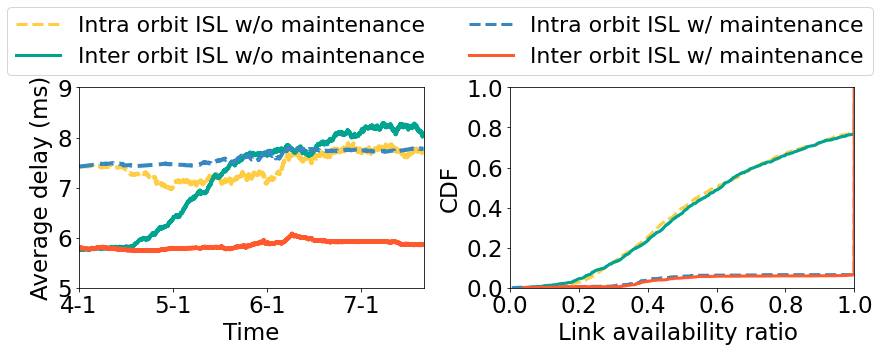

In [7]:
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(nrows=1, ncols=2)
ax= fig.axes
#c=['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51',"#3F72AF","#112D4E"]
c = ["#00A491","#FF592D","#FFCD43","#3787C0"]

fs=23

ax[0].plot([delay_decay_intra[i]/isl_num_intra_decay[i]/300 for i in range(len(delay_decay_intra))],label='Intra orbit ISL w/o maintenance',lw=4,c=c[2],linestyle='--')
ax[0].plot([delay_decay_inter[i]/isl_num_inter_decay[i]/300 for i in range(len(delay_decay_intra))],label='Inter orbit ISL w/o maintenance',lw=4,c=c[0])
ax[0].plot([delay_no_decay_intra[i]/isl_num_intra_no_decay[i]/300 for i in range(len(delay_decay_intra))],label='Intra orbit ISL w/ maintenance',lw=4,c=c[3],linestyle='--')
ax[0].plot([delay_no_decay_inter[i]/isl_num_inter_no_decay[i]/300 for i in range(len(delay_decay_intra))],label='Inter orbit ISL w/ maintenance',lw=4,c=c[1])


ax[0].set_xlabel("Time",fontsize=fs)
ax[0].set_ylabel("Average delay (ms)",fontsize=fs)
ax[0].set_ylim(5,9)
ax[0].set_xlim(0,len(isl_num_intra_decay))
# ax[0].set_xticks(range(0,2640,15*24))
# ax[0].set_xticklabels(['4-1','4-15','5-1','5-15','6-1','6-15','7-1','7-15'],fontsize=fs )
ax[0].set_xticks(range(0,2640,30*24))
ax[0].set_xticklabels(['4-1','5-1','6-1','7-1'],fontsize=fs )
ax[0].tick_params(axis='y', labelsize=fs )



# plt.tight_layout()
# plt.savefig('latency-decay.pdf')

x=[[] for _ in range(4)]
y=[[] for _ in range(4)]
ecdf=[0 for _ in range(4)]
labels=['Intra orbit ISL w/o maintenance','Inter orbit ISL w/o maintenance','Intra orbit ISL w/ maintenance','Inter orbit ISL w/ maintenance']
datalist=[ratio_decay_intra,ratio_decay_inter,ratio_no_decay_intra,ratio_no_decay_inter]
for i in range(4):
    
    ecdf[i] = sm.distributions.ECDF(datalist[i])
    x[i] = np.linspace(min(datalist[i]), max(datalist[i]), len(datalist[i]))
    y[i] = ecdf[i](x[i])


ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 1)

ax[1].plot(x[0], y[0],linewidth=3, label=labels[0],c=c[2],linestyle='--')
ax[1].plot(x[1], y[1],linewidth=3, label=labels[1],c=c[0])
ax[1].plot(x[2], y[2],linewidth=3, label=labels[2],c=c[3],linestyle='--')
ax[1].plot(x[3], y[3],linewidth=3, label=labels[3],c=c[1])
    
ax[1].set_xlabel("Link availability ratio ",fontsize=fs)
ax[1].set_ylabel("CDF",fontsize=fs)
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax[1].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=fs )
ax[1].set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax[1].set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=fs )
# ax[1].tick_params(axis='x', labelsize=fs )
# ax[1].tick_params(axis='y', labelsize=fs )





lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels,ncol=2,fontsize=fs-1,bbox_to_anchor=(1,1.25))
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('figure16.pdf',bbox_inches='tight')
plt.show()